In [1]:
import numpy as np
import torch
from diffusers import StableDiffusion3Pipeline
from sd3_lora_celeba.visualizer import TextTokenAndImageVisualizer
from sd3_lora_celeba.ncut import get_ncut_colors
from sd3_lora_celeba.attention import generate_image_and_get_affinity

In [2]:
pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

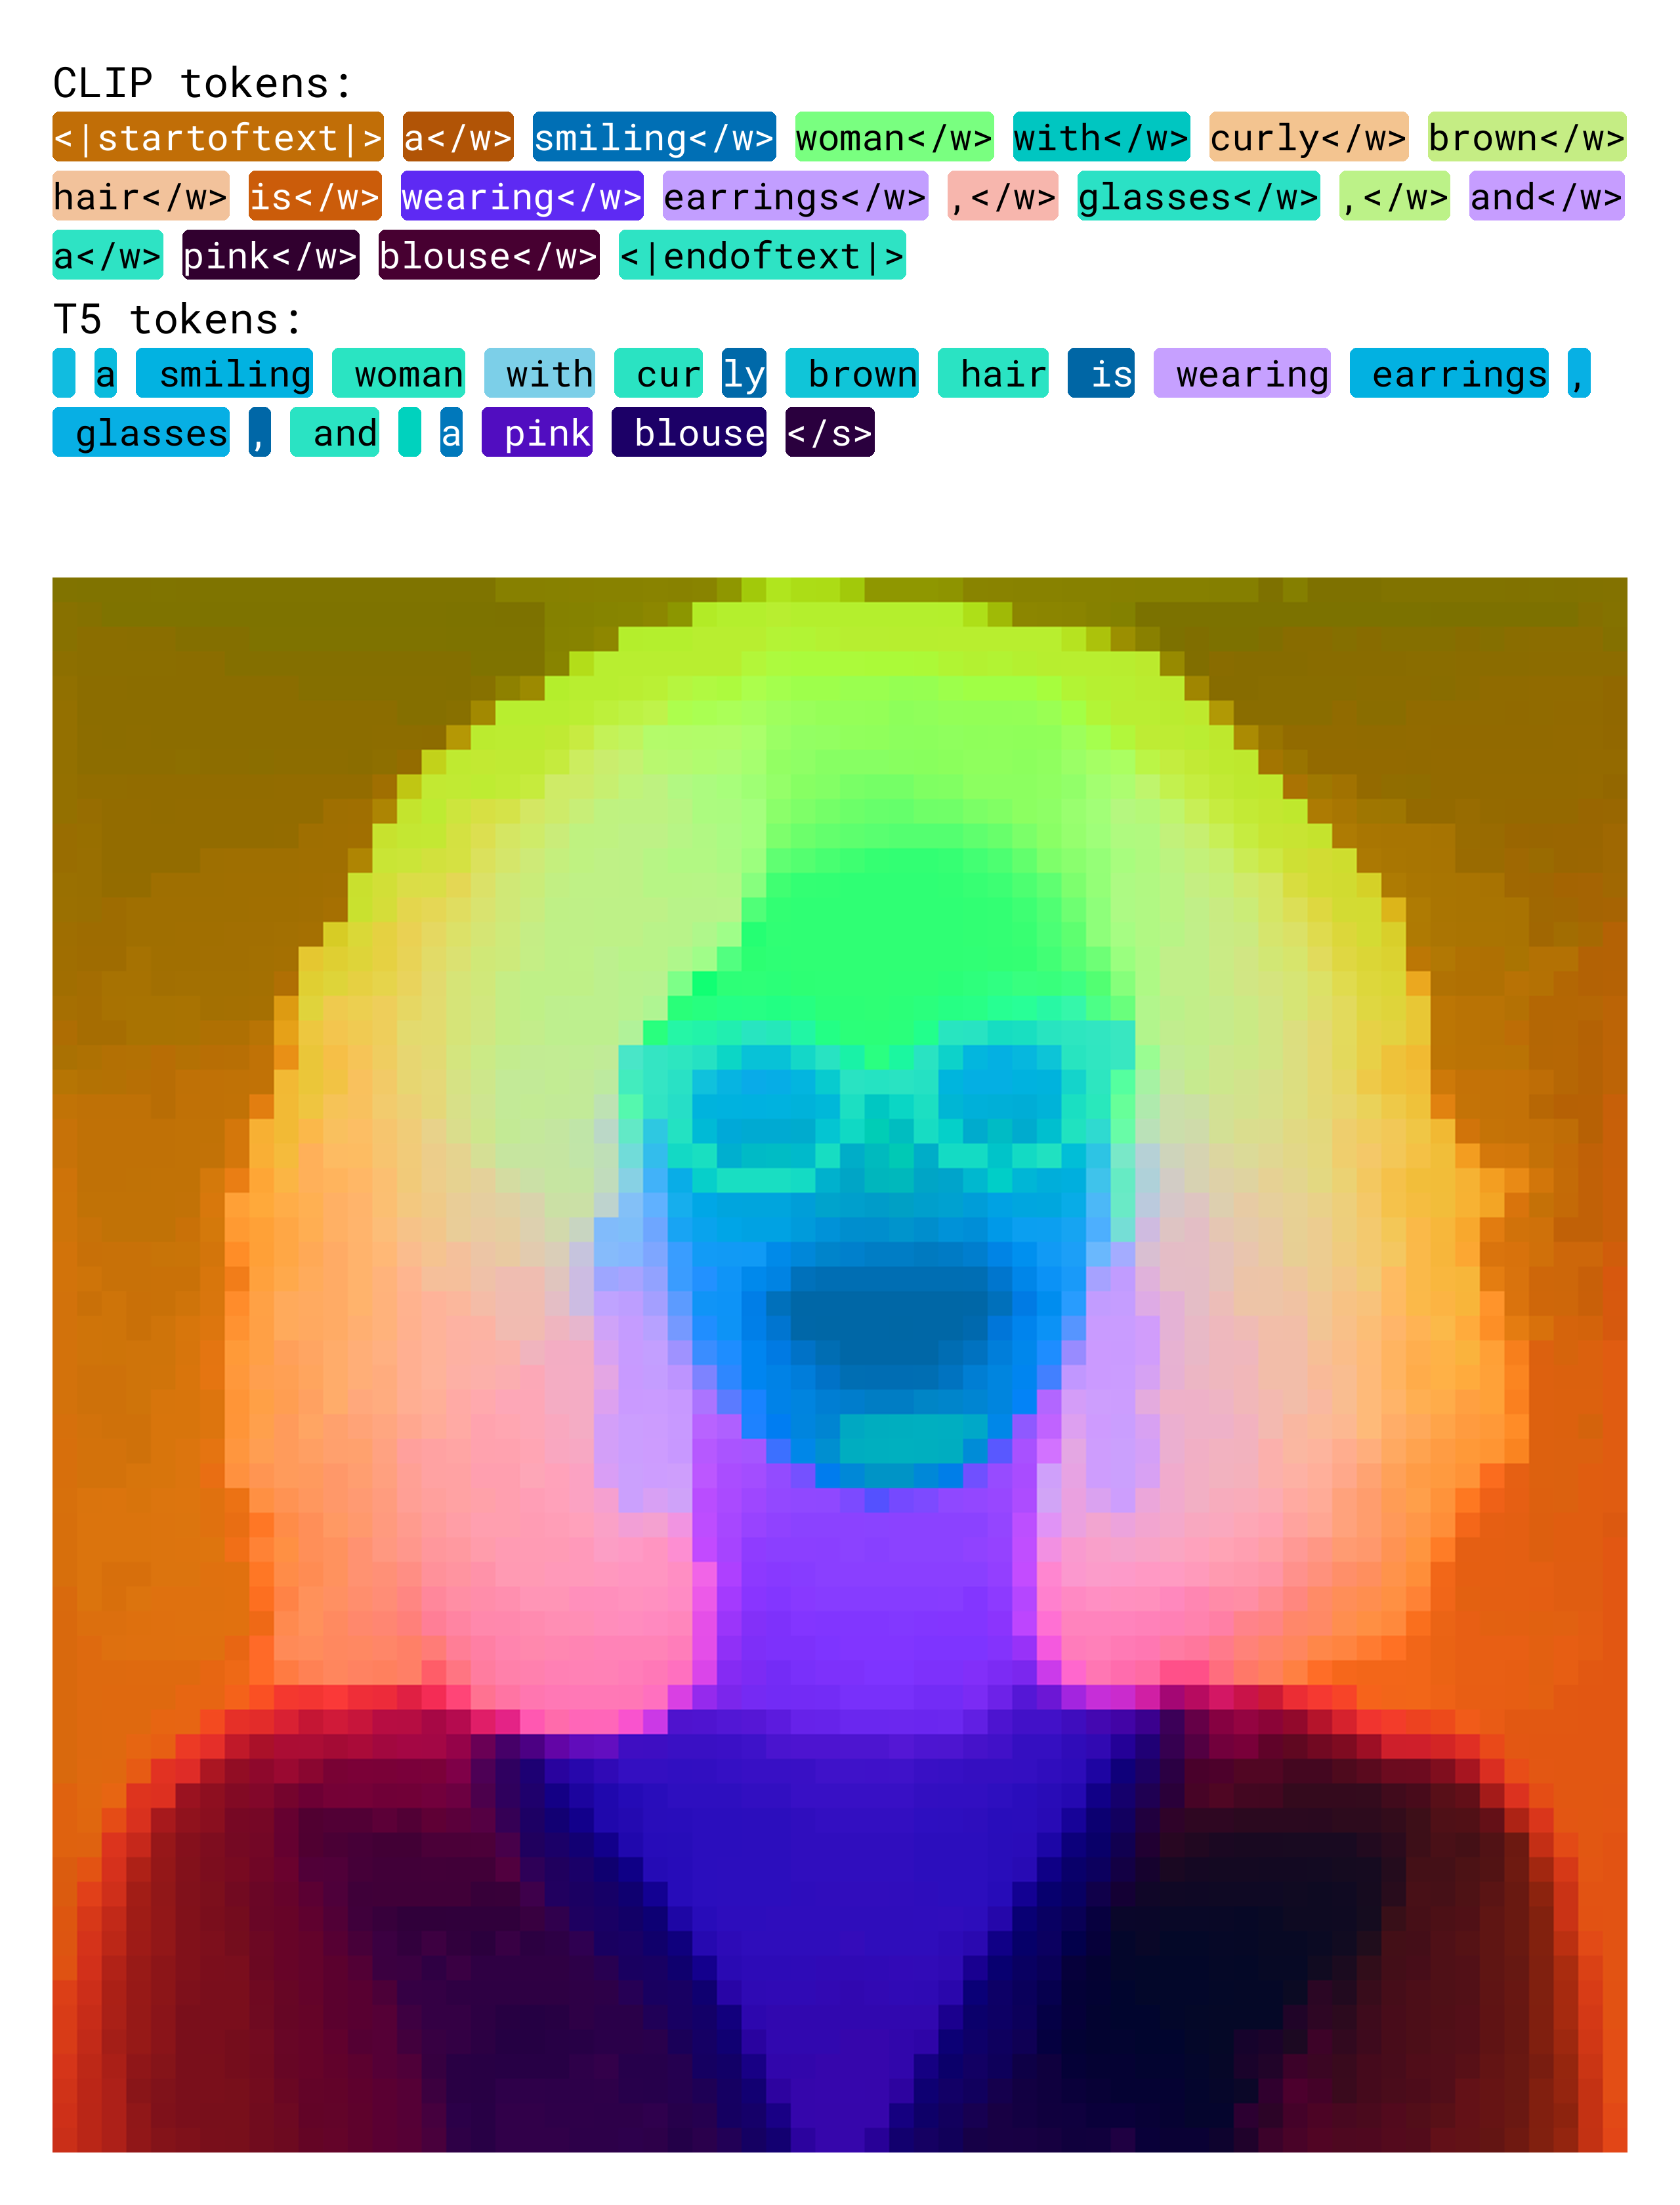

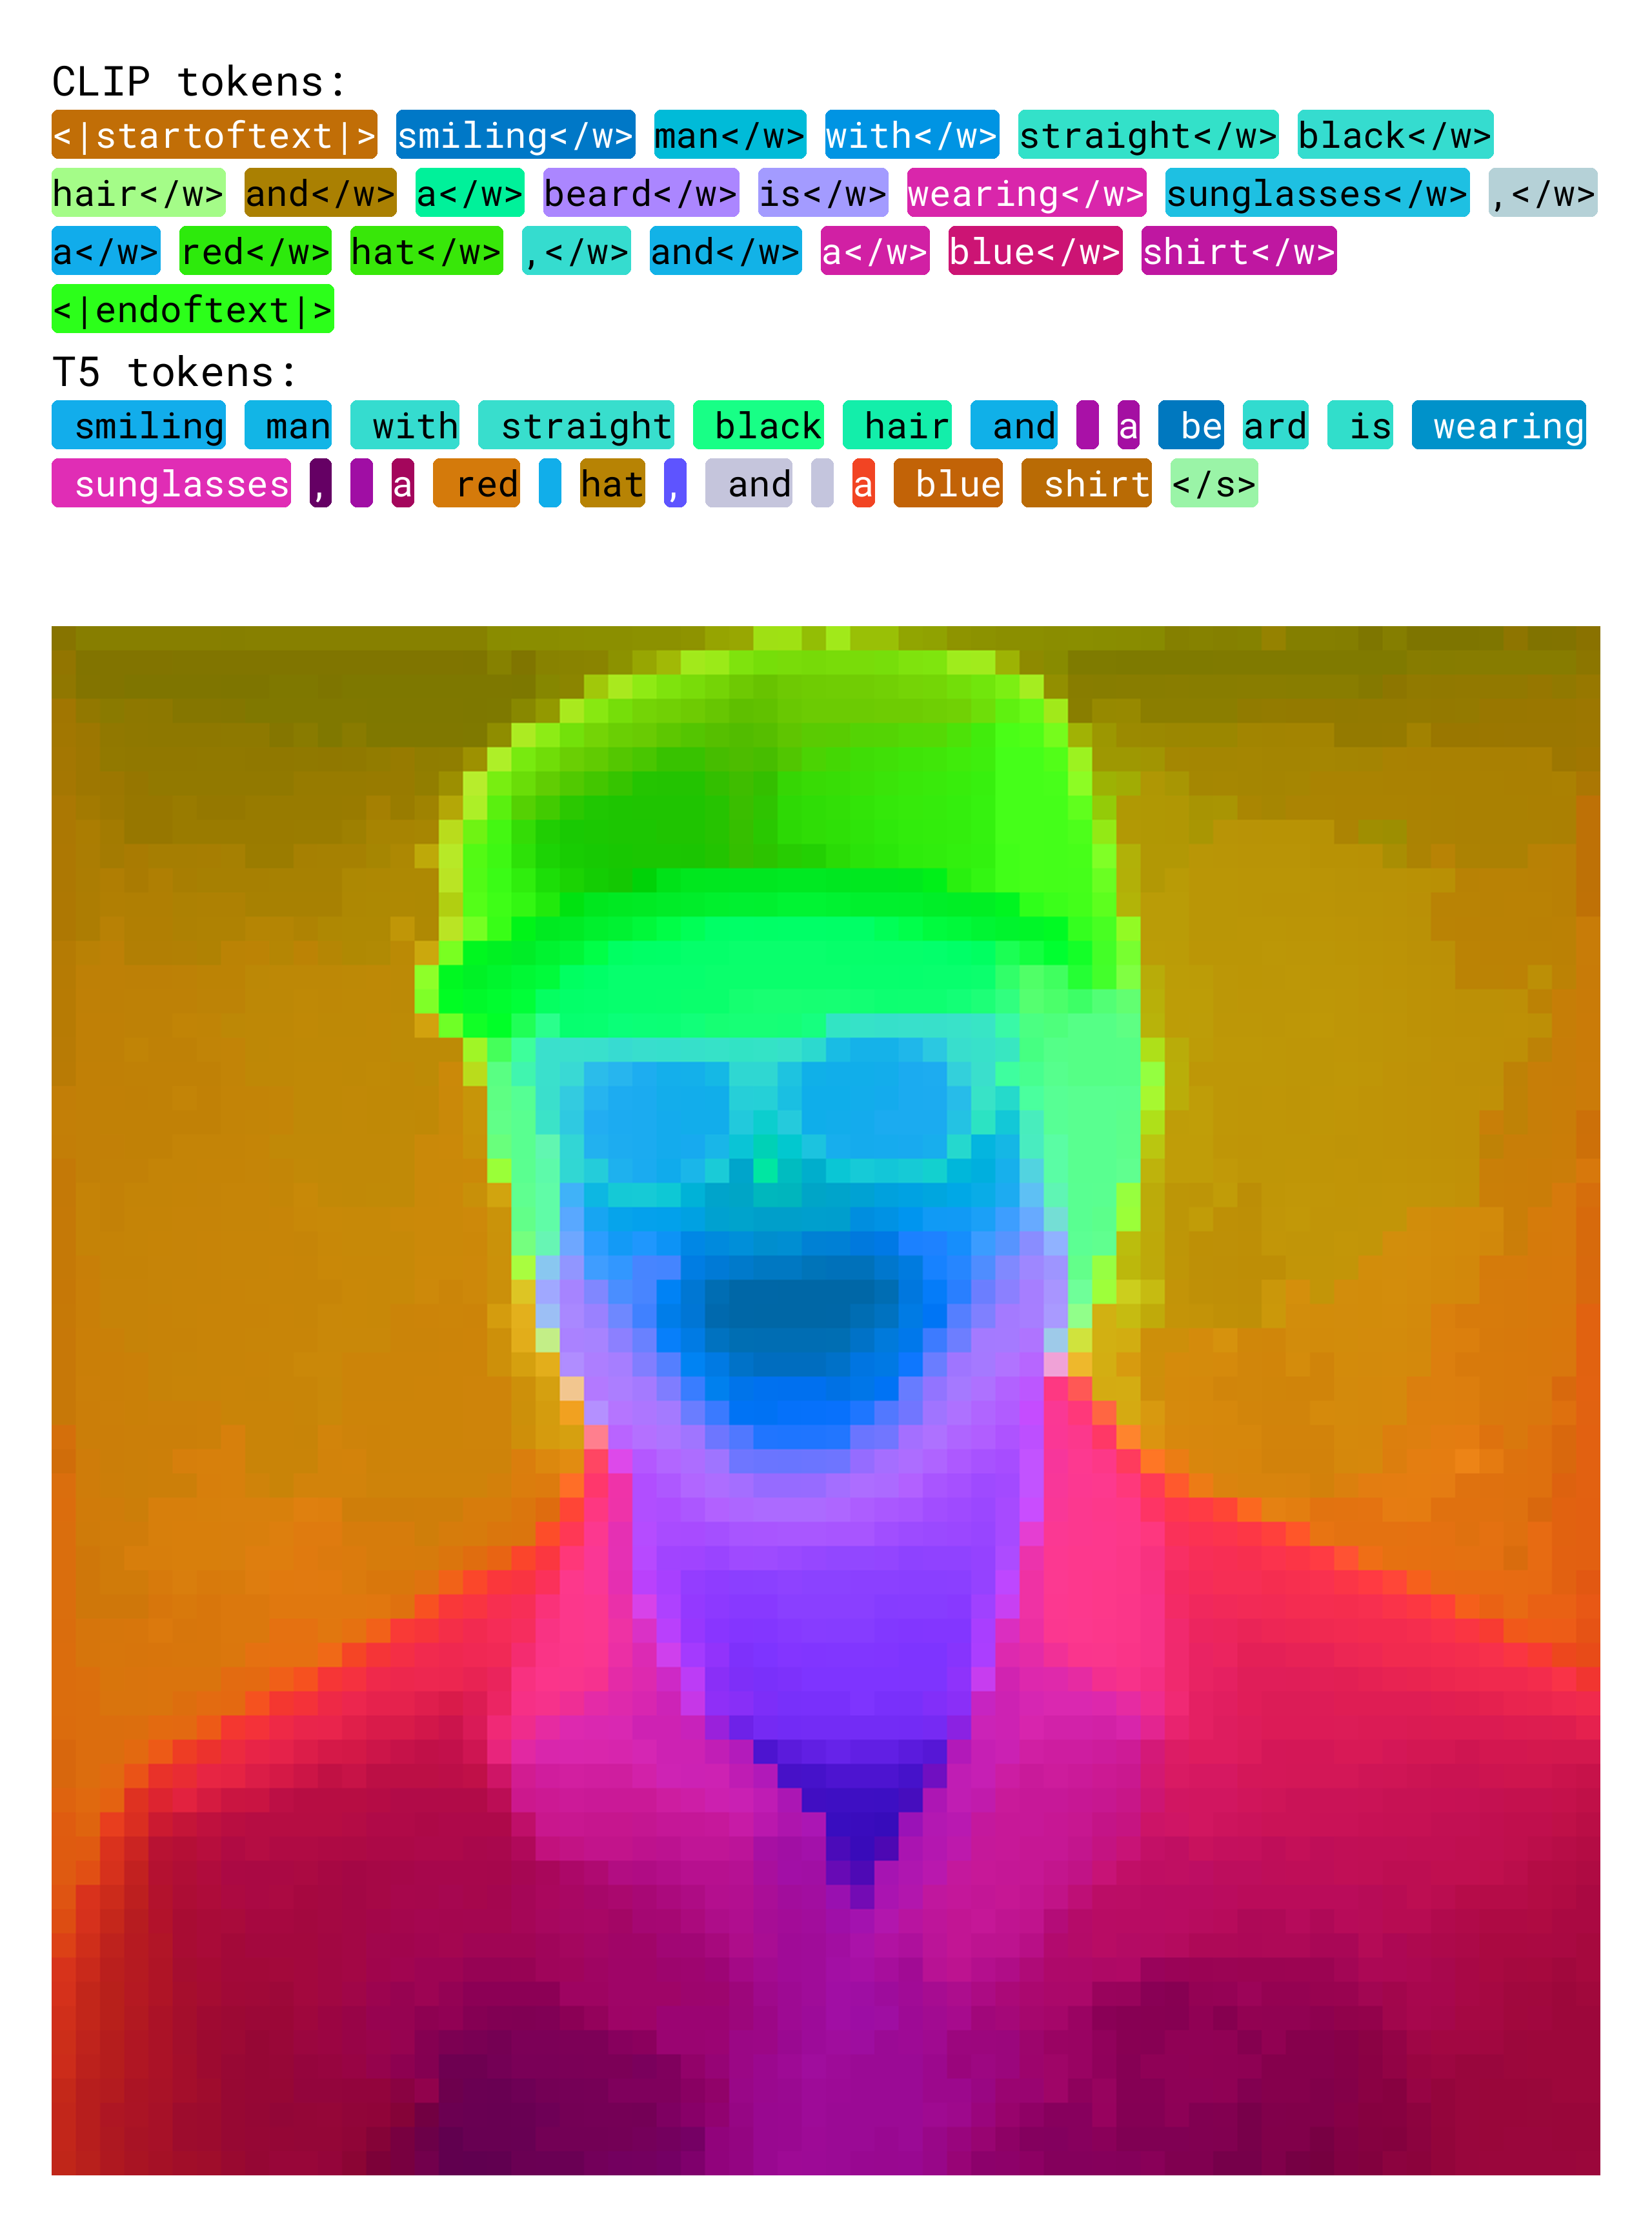

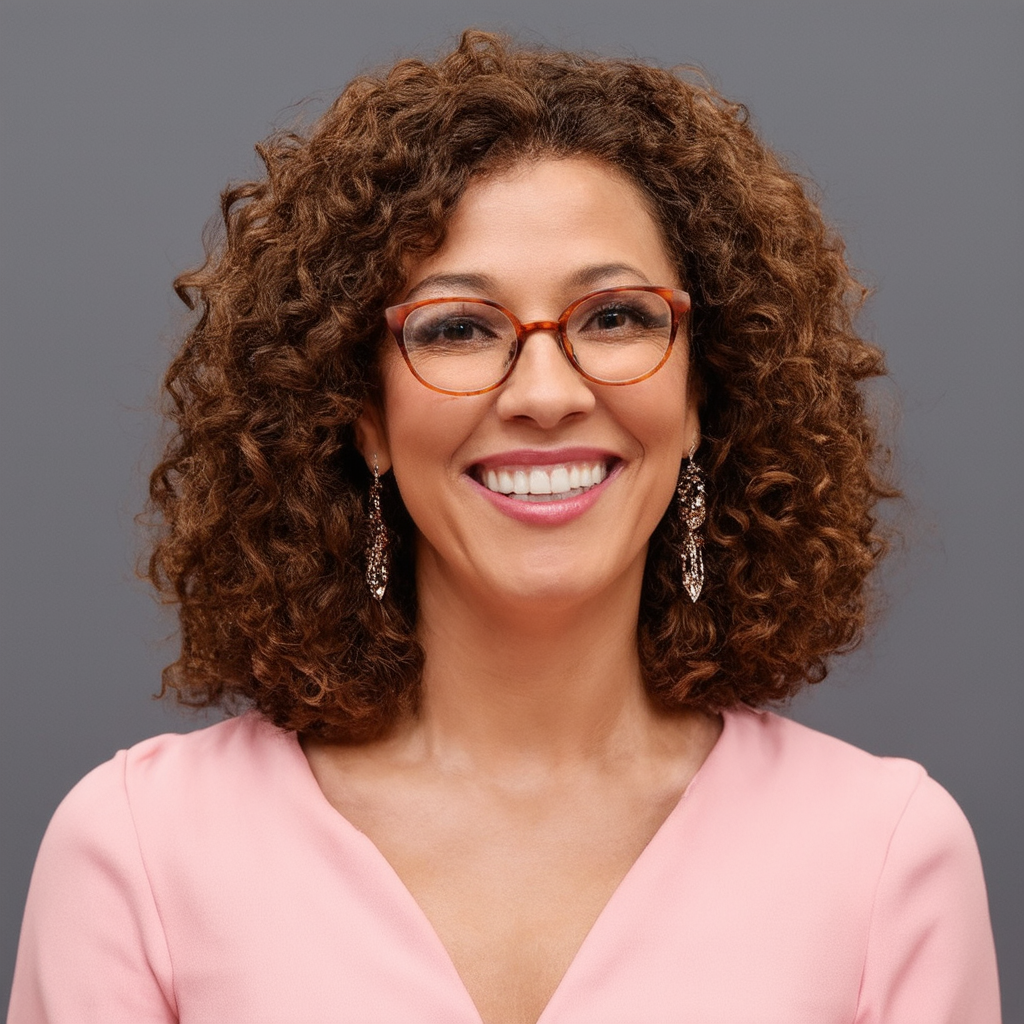

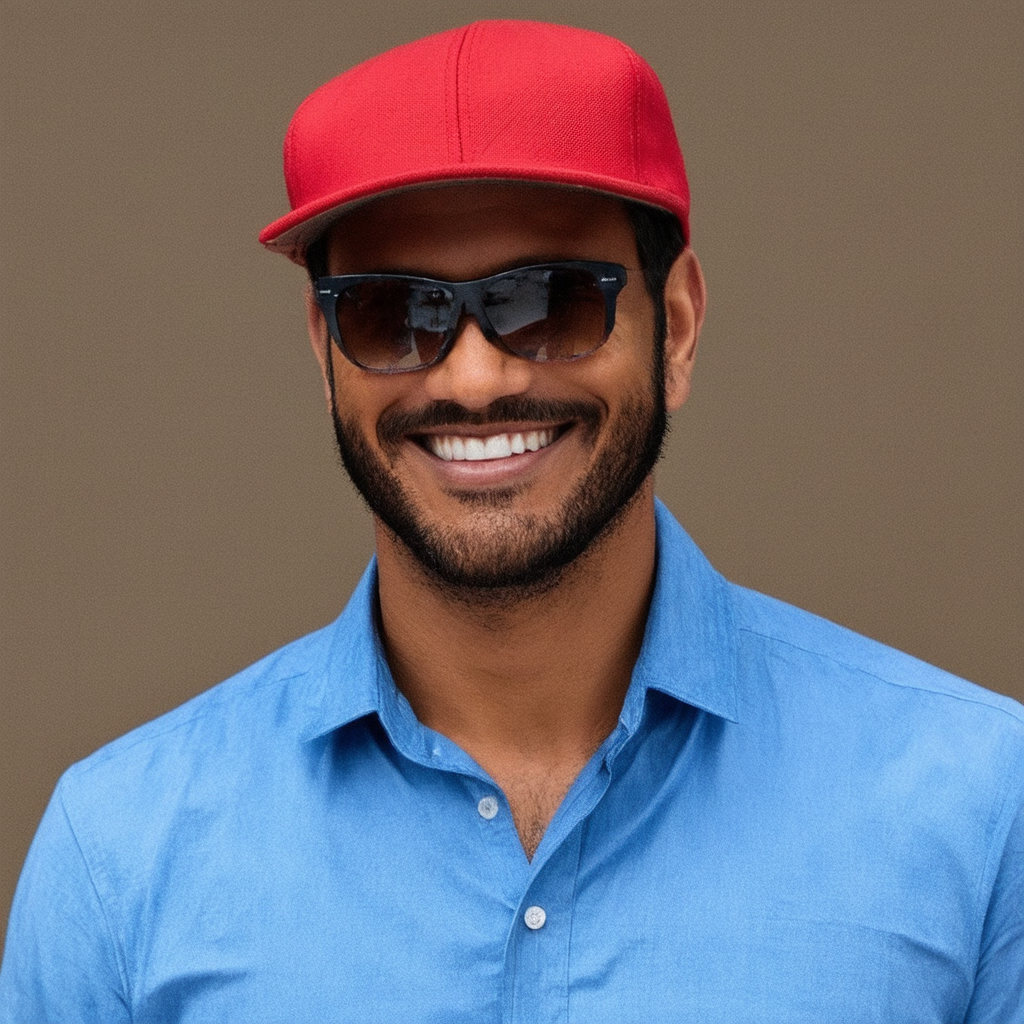

In [3]:
prompts = [
    "a smiling woman with curly brown hair is wearing earrings, glasses, and a pink blouse",
    "smiling man with straight black hair and a beard is wearing sunglasses, a red hat, and a blue shirt",
]

generated_images, affinity = generate_image_and_get_affinity(
    pipeline,
    inference_step=23,
    transformer_blocks=list(range(7, 21)),
    prompt=prompts,
    num_inference_steps=28,
    guidance_scale=3.0,
    random_seed=42,
    affinity_method="attention_weight",
)

ncut_colors = np.split(
    get_ncut_colors(affinity, num_eigenvectors=30, device="cuda"), len(prompts)
)

visualizer = TextTokenAndImageVisualizer()

for prompt, example_colors in zip(prompts, ncut_colors):
    clip_token_ids = pipeline.tokenizer(
        prompt,
        padding=False,
        max_length=77,
        truncation=True,
    )["input_ids"]
    clip_tokens = pipeline.tokenizer.convert_ids_to_tokens(clip_token_ids)

    t5_token_ids = pipeline.tokenizer_3(
        prompt,
        padding=False,
        max_length=256,
        truncation=True,
        add_special_tokens=True,
    )["input_ids"]
    t5_tokens = pipeline.tokenizer_3.convert_ids_to_tokens(t5_token_ids)

    overlay_colors = example_colors[0:4096].reshape(64, 64, 3)
    clip_token_colors = example_colors[4096 : 4096 + len(clip_tokens)]
    t5_token_colors = example_colors[4096 + len(clip_tokens) :]

    figure = visualizer.visualize_data(
        clip_tokens,
        clip_token_colors,
        t5_tokens,
        t5_token_colors,
        image=None,
        overlay_colors=overlay_colors,
    )
    display(figure)

for image in generated_images:
    display(image)